# Stock Prices Prediction


## Overview

Predicting the stock market is certainly one of the most difficult things to do. There are so many factors involved (physical factors vs. physhological, rational and irrational behaviour, etc). All these aspects combine to make share prices volatile and very difficult to predict with a high degree of accuracy.

Can we use machine learning in this domain? We can use features like the stock price, revenue results, latest announcements about an organization, etc., machine learning techniques have the potential to unearth patterns and insights we didn’t see before, and these can be used to make unerringly accurate predictions.


**Contents**
1. Problem Statement
2. Moving Average
3. Linear Regression
4. k-Nearest Neighbors
5. Auto ARIMA
6. Prophet
7. Long Short Term Memory (LSTM)



## **1. Problem Statement**

In general terms we can divide the stock market analysis into two big areas:
- Fundamental Analysis
- Technical Analysis.

**Fundamental Analysis**: involves analyzing the company’s future profitability on the basis of its current business environment and financial performance.
**Technical Analysis**: on the other hand, includes reading the charts and using statistical figures to identify the trends in the stock market.

As you might have guessed, our focus will be on the technical analysis part. We’ll be using a dataset (you can find historical data for various stocks here).


### Load Basic Libraries

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext watermark
%watermark -v -m -p numpy,pandas,skmultilearn -g

import os
import sys
import re
from tqdm import tqdm
import yaml
import watermark
from math import floor
from random import random
from pprint import pprint as pp
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns
import pandas_profiling
from pandas.plotting import register_matplotlib_converters    # for pandas_profiling

from sklearn.preprocessing import MinMaxScaler                # data normalization

register_matplotlib_converters()                              # for pandas_profiling
sys.path.append(os.pardir)
# Set figure size
rcParams['figure.figsize'] = 20,14

from src.ts_func import add_datepart


CPython 3.7.3
IPython 7.5.0

numpy 1.16.4
pandas 0.24.2
skmultilearn unknown

compiler   : GCC 7.3.0
system     : Linux
release    : 5.0.0-25-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit
Git hash   : f0f2ce613876e9193f297b7eeebb7e179a927ebc


### Constants

In [2]:
INPUT_DATA = "../data/raw/nse_TataGlobal.csv"
INPUT_DATA2 = "../data/raw/MMM.csv"

### Load and summarize data

As we want it to be a time series we specify the format of the date and load it as index:

In [3]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
df = pd.read_csv(
    INPUT_DATA, 
    parse_dates=['Date'],    # specifies the column which contains the date-time information
    date_parser=dateparse,  # Specifies a function which converts an input string into datetime variable.
    index_col='Date')

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1235 entries, 2018-10-08 to 2013-10-08
Data columns (total 7 columns):
Open                    1235 non-null float64
High                    1235 non-null float64
Low                     1235 non-null float64
Last                    1235 non-null float64
Close                   1235 non-null float64
Total Trade Quantity    1235 non-null float64
Turnover (Lacs)         1235 non-null float64
dtypes: float64(7)
memory usage: 77.2 KB


,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
Date,,,,,,,
2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


In [4]:
df.describe()

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
count,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1.235000e+03,1235.000000
mean,168.954858,171.429069,166.402308,168.736356,168.731053,2.604151e+06,4843.166502
std,51.499145,52.436761,50.542919,51.587384,51.544928,2.277028e+06,5348.919832
min,103.000000,104.600000,100.000000,102.600000,102.650000,1.001800e+05,128.040000
25%,137.550000,138.925000,135.250000,137.175000,137.225000,1.284482e+06,1801.035000
50%,151.500000,153.250000,149.500000,151.200000,151.100000,1.964885e+06,3068.510000
75%,169.000000,172.325000,166.700000,169.100000,169.500000,3.095788e+06,5852.600000
max,327.700000,328.750000,321.650000,325.950000,325.750000,2.919102e+07,55755.080000


There are multiple variables in the dataset:
- date
- open, high, low, last, close
- total_trade_quantity
- turnover

The columns *Open* and *Close* represent the starting and final price at which the stock is traded on a particular day. <br>
*High, Low and Last* represent the maximum, minimum, and last price of the share for the day. <br>
*Total Trade Quantity* is the number of shares bought or sold in the day and *Turnover* (Lacs) is the turnover of the particular company on a given date.

Another important thing to notice about the data is the missing dates. The market is closed on weekends and public holidays.

The profit or loss calculation is usually determined by the closing price of a stock for the day, hence we will consider the closing price as the target variable. Let’s plot the target variable to understand how it’s shaping up in our data:

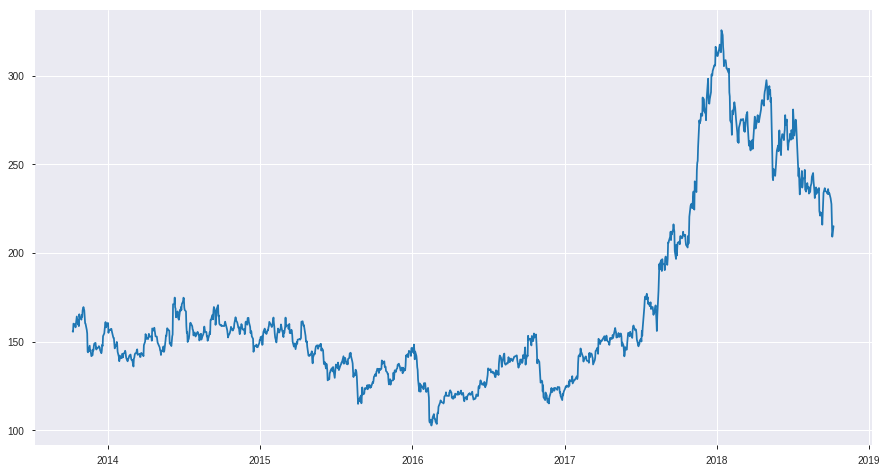

In [5]:
plt.figure(figsize=(15, 8))
plt.plot(df['Close'], label='Close Price history');

Divide the data: Train and Test

In [6]:
df = df.sort_index(ascending=True, axis=0)
data = df.copy()
n_tr = 985
df_train = data[:n_tr].copy()
df_test = data[n_tr:].copy()

print(f'Total: {data.shape} \nTrain: {df_train.shape} \nTest: {df_test.shape}')

Total: (1235, 7) 
Train: (985, 7) 
Test: (250, 7)


## **2. Moving Average**

*Averaging* is used in many applications to sum and understand the values and behaviours of many things.

In the *Moving Average*, the predicted closing price for each day will be the average of a set of previously observed values within a specific time window, for example the latest 20 values.


In [7]:
# Predictions using the moving average
window = 250
preds = []
for i in range(0, window):
    a = df_train['Close'][len(df_train) - window + i:].sum() + sum(preds)
    b = a/window
    preds.append(b)
    
# Calculate RMSE
calculate_rmse = lambda x, y: np.sqrt(np.mean(np.power((np.array(x) - y), 2)))
rmse = calculate_rmse(df_test['Close'], preds)
print(f'RMSE: {round(rmse, 3)}')

RMSE: 105.164


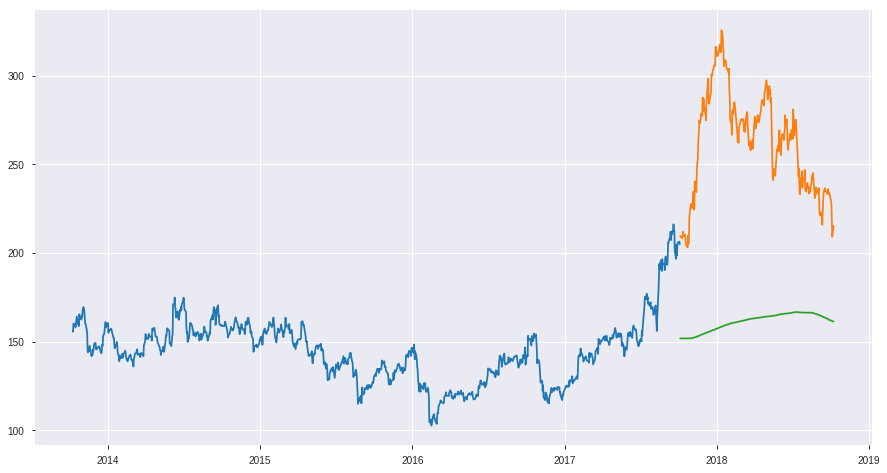

In [8]:
# Plot to have a visual representation...
df_test['Predictions'] = 0
df_test['Predictions'] = preds

plt.figure(figsize=(15, 8))
plt.plot(df_train['Close']);
plt.plot(df_test[['Close', 'Predictions']]);

The graph is very clear, the RMSE value is close to 105 but the results are not promising. The predicted values are the average of the observed values and thus in the same range and they try to replicate the trend with an initial increase and posterior decrease.

## **3. Linear Regression**

The most basic ML algorithm that can be implemented on this data is linear regression. The linear regression model returns an equation that determines the relationship between the independent variables and the dependent variable.


In [9]:
add_datepart(data, 'index')
data.drop('dateElapsed', axis=1, inplace=True)

This creates features such as:

‘Year’, ‘Month’, ‘Week’, ‘Day’, ‘Dayofweek’, ‘Dayofyear’, ‘Is_month_end’, ‘Is_month_start’, ‘Is_quarter_end’, ‘Is_quarter_start’,  ‘Is_year_end’, and  ‘Is_year_start’.

Apart from this we can add our own set of features. For instance if we have the hypothesis that the first and last days of the week could potentially affect the closing price of the stock far more than the other days we can create a feature for it:

In [10]:
data['mon_fri'] = data['dateDayofweek'].apply(lambda x: x in [0, 4])
data['mon_fri'] = data['mon_fri'].astype(int)

In [11]:
# Split data as before
df_train = data[:n_tr].copy()
df_test = data[n_tr:].copy()

x_tr = df_train.drop('Close', axis=1)
y_tr = df_train['Close']
x_te = df_test.drop('Close', axis=1)
y_te = df_test['Close']

In [12]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()
linear_model.fit(x_tr, y_tr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Evaluate Model:

In [24]:
# make predictions and find the rmse
preds = linear_model.predict(x_te)
rmse = calculate_rmse(y_te, preds)
print(f'RMSE: {round(rmse, 3)}')

RMSE: 0.621


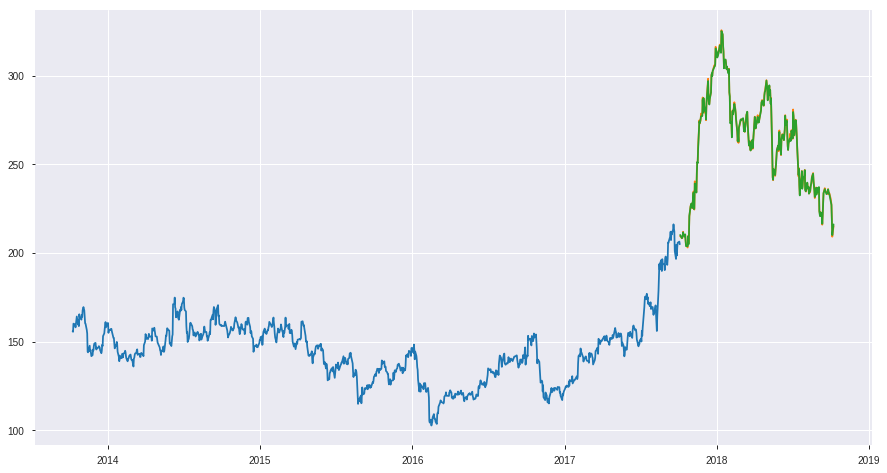

In [25]:
# Plot to have a visual representation...
df_test['Predictions'] = 0
df_test['Predictions'] = preds

df_test.index = data[n_tr:].index
df_train.index = data[:n_tr].index
plt.figure(figsize=(15, 8))
plt.plot(df_train['Close']);
plt.plot(df_test[['Close', 'Predictions']]);

## **4. k-Nearest Neighbors**

Based on the independent variables kNN finds the similarity between new data points and old data points.


In [26]:
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV

In [29]:
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale data
x_tr_scaled = scaler.fit_transform(x_tr)
x_tr= pd.DataFrame(x_tr_scaled)
x_te_scaled = scaler.fit_transform(x_te)
x_te = pd.DataFrame(x_te_scaled)

# gridsearch to find the best parameter
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)

# fit model and make predictions
model.fit(x_tr,y_tr)
preds = model.predict(x_te)

# Evaluation
rmse = calculate_rmse(y_te, preds)
print(f'RMSE: {round(rmse, 3)}')

RMSE: 114.244


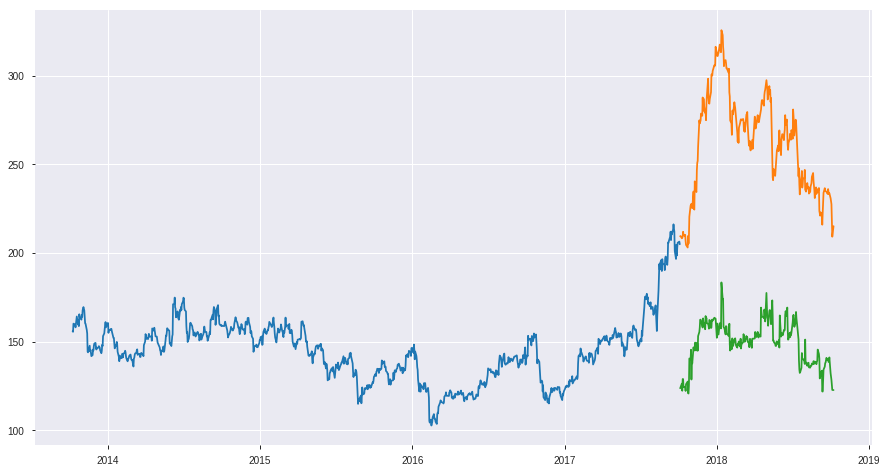

In [30]:
df_test['Predictions'] = 0
df_test['Predictions'] = preds

plt.figure(figsize=(15, 8))
plt.plot(df_train['Close']);
plt.plot(df_test[['Close', 'Predictions']]);

## **5. Auto ARIMA**





## **6. Prophet**







## **7. Long Short Term Memory (LSTM)**



In [ ]:
df.Close.rolling(window).mean()